In [1]:
%load_ext autoreload
%autoreload 1
%aimport models

from models import *

(Re)loading load_data
(Re)loading models


In [2]:
trials = behavior[~behavior.excluded & behavior.session.isin(['wn_experiment', 'wn_visual'])]
pupils = samples.merge(trials, left_on=['subjectId', 'session', 'Trial'], right_on=['subjectId', 'session', 'trialCount'])
corrPupils = baselineCorrect(pupils)

In [3]:
fields = ['subjectId', 'session', 'condType', 'trialCount']
pp = pd.DataFrame()
for field, startTime, endTime in [('earlyPupil', '1s', '2s'), ('latePupil', '3s', '4s')]:
    response = corrPupils[corrPupils.offsetFromStim.between(pd.to_timedelta(startTime), pd.to_timedelta(endTime))]
    pp[field] = response.groupby(fields).Pupil.mean().groupby(fields[:-1]).mean()

pp.reset_index(inplace=True)

ShapiroResult(statistic=0.9901049643178453, pvalue=0.8016758312236105)


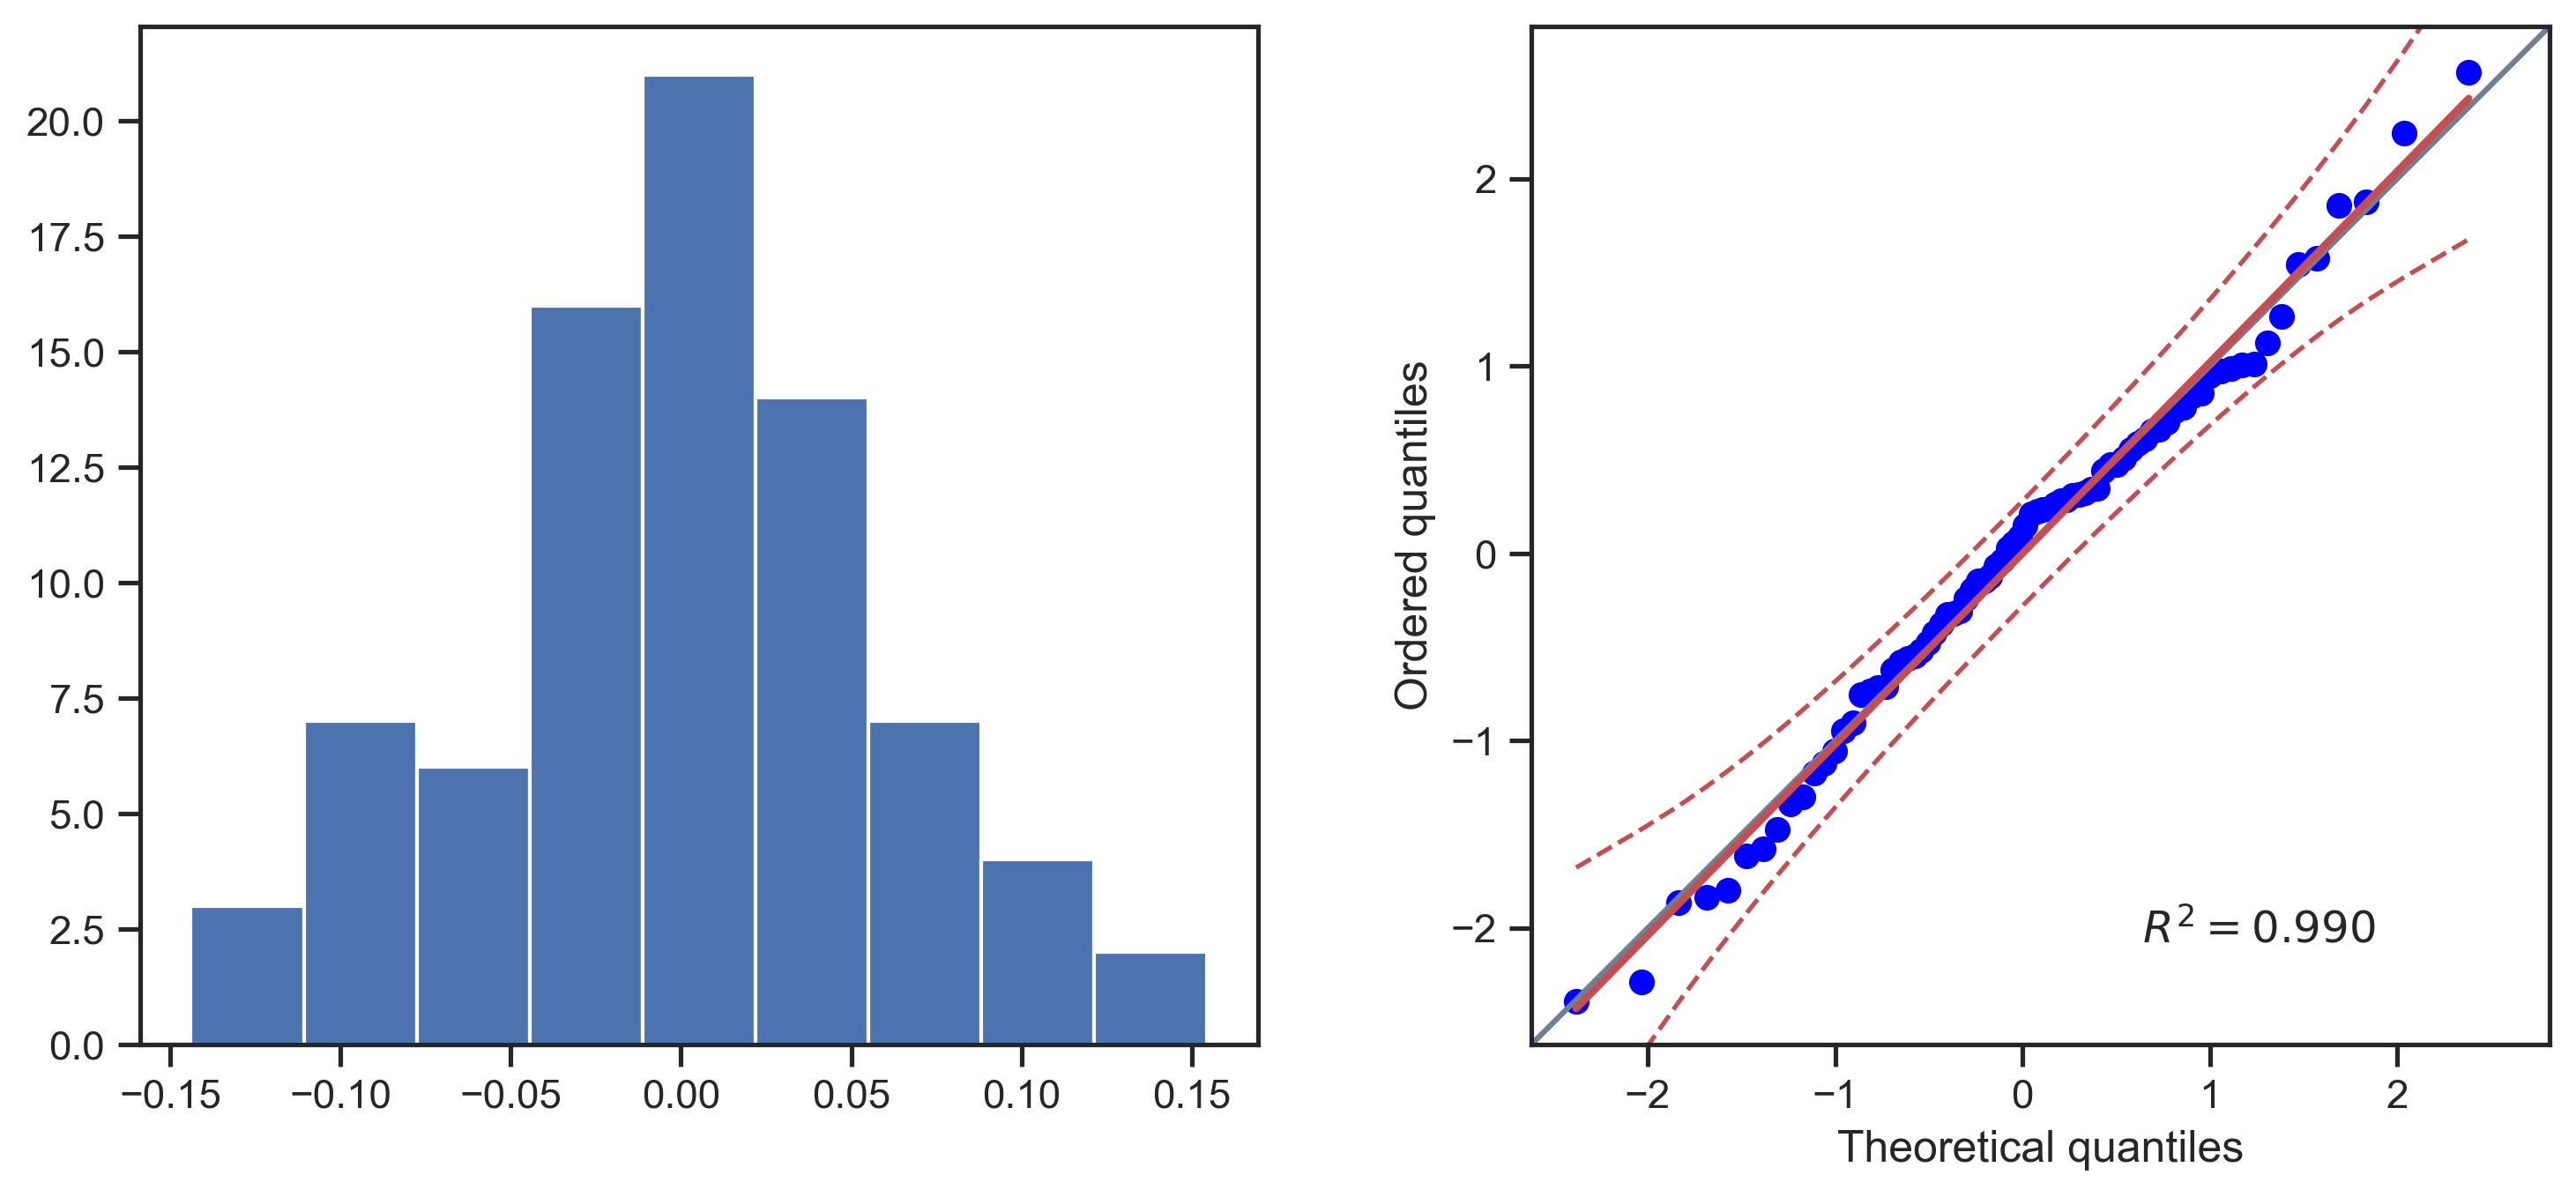

In [4]:
checkResiduals(smf.mixedlm('earlyPupil ~ C(session) + C(condType) + C(session)*C(condType)', pp, groups='subjectId'))

ShapiroResult(statistic=0.9737227737520499, pvalue=0.09811718506061712)


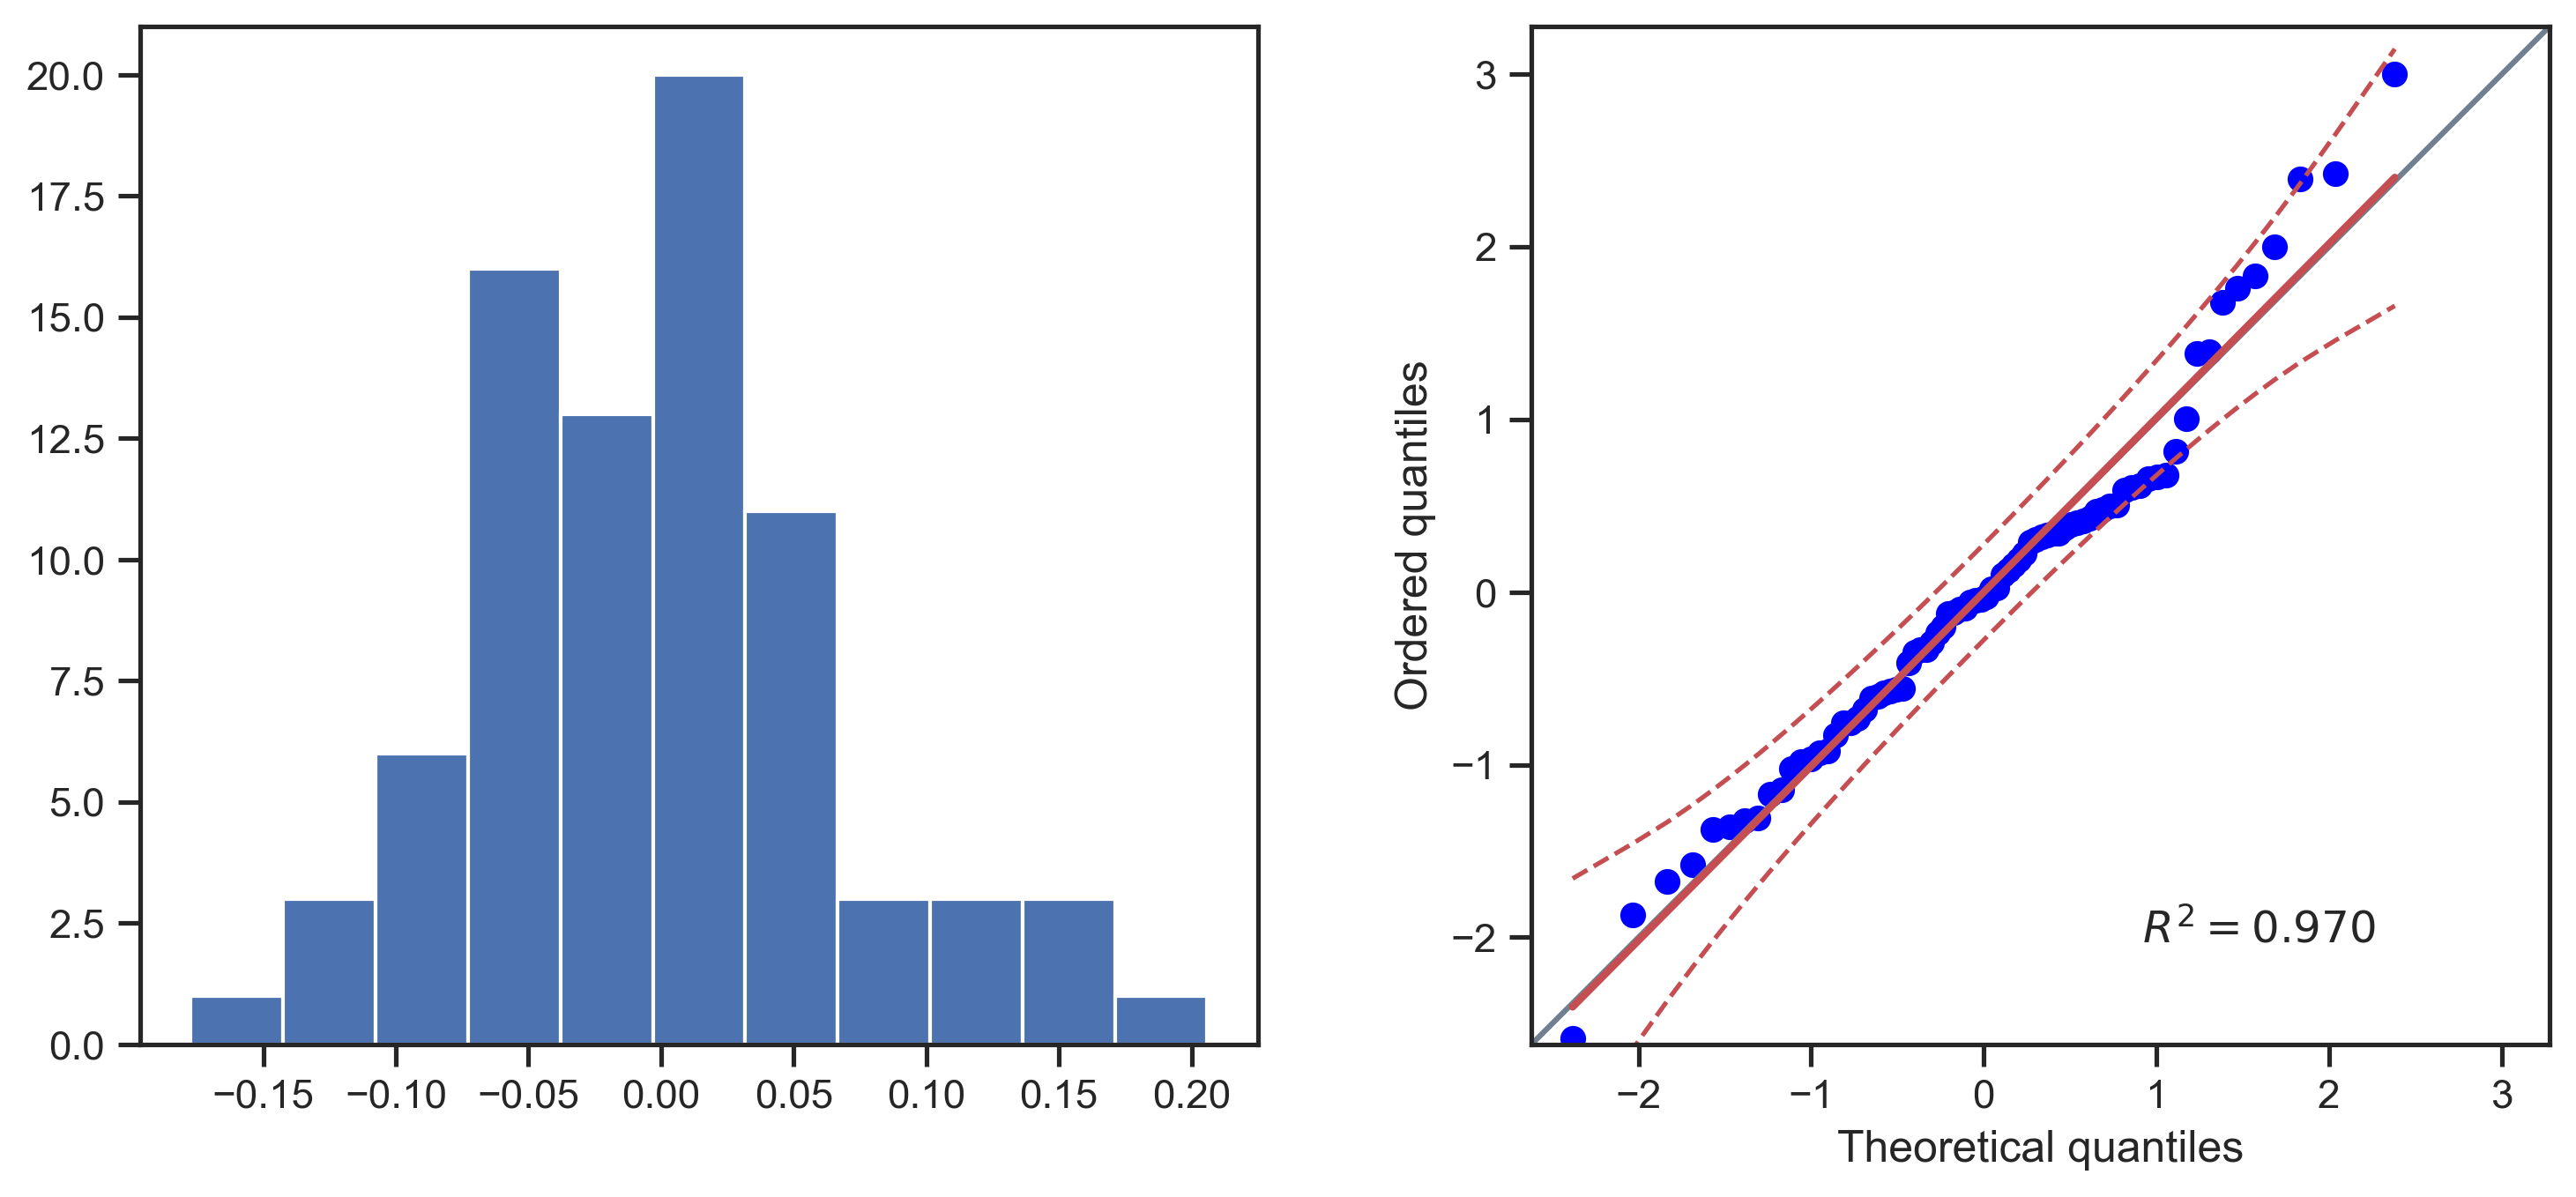

In [5]:
checkResiduals(smf.mixedlm('latePupil ~ C(session) + C(condType) + C(session)*C(condType)', pp, groups='subjectId'))

In [6]:
import seaborn as sns
import matplotlib.ticker as ticker

def condInteraction(data, conds, field, ax=None):
    if ax is None:
        ax = plt.figure(figsize=(6, 5), dpi=100).subplots()
    ax.set_xlabel('Condition')
    ax.set_ylabel('Pupil size change [mm]')
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    df = data.query("condType.isin(@conds)")
    sessionPal = sns.color_palette(['0.2', '0.8'])
    sns.pointplot(df.query("session!='interaction'"), x='condType', y=field, errorbar=None, order=conds, hue='session', palette=sessionPal, ax=ax)
    condPal = sns.color_palette([condColors[c] for c in conds])
    sns.pointplot(df.query("session.str.endswith('experiment')"), x='condType', y=field, errorbar='se', order=conds, hue='condType', palette=condPal, ax=ax)
    sns.pointplot(df.query("session.str.endswith('visual')"), x='condType', y=field, errorbar='se', order=conds, hue='condType', palette=condPal, ax=ax)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=0.05))
    ax.yaxis.set_tick_params(rotation=90)
    ax.legend(['experiment', 'visual control'], title=None, loc=('lower right' if field.startswith('early') else 'upper left'))

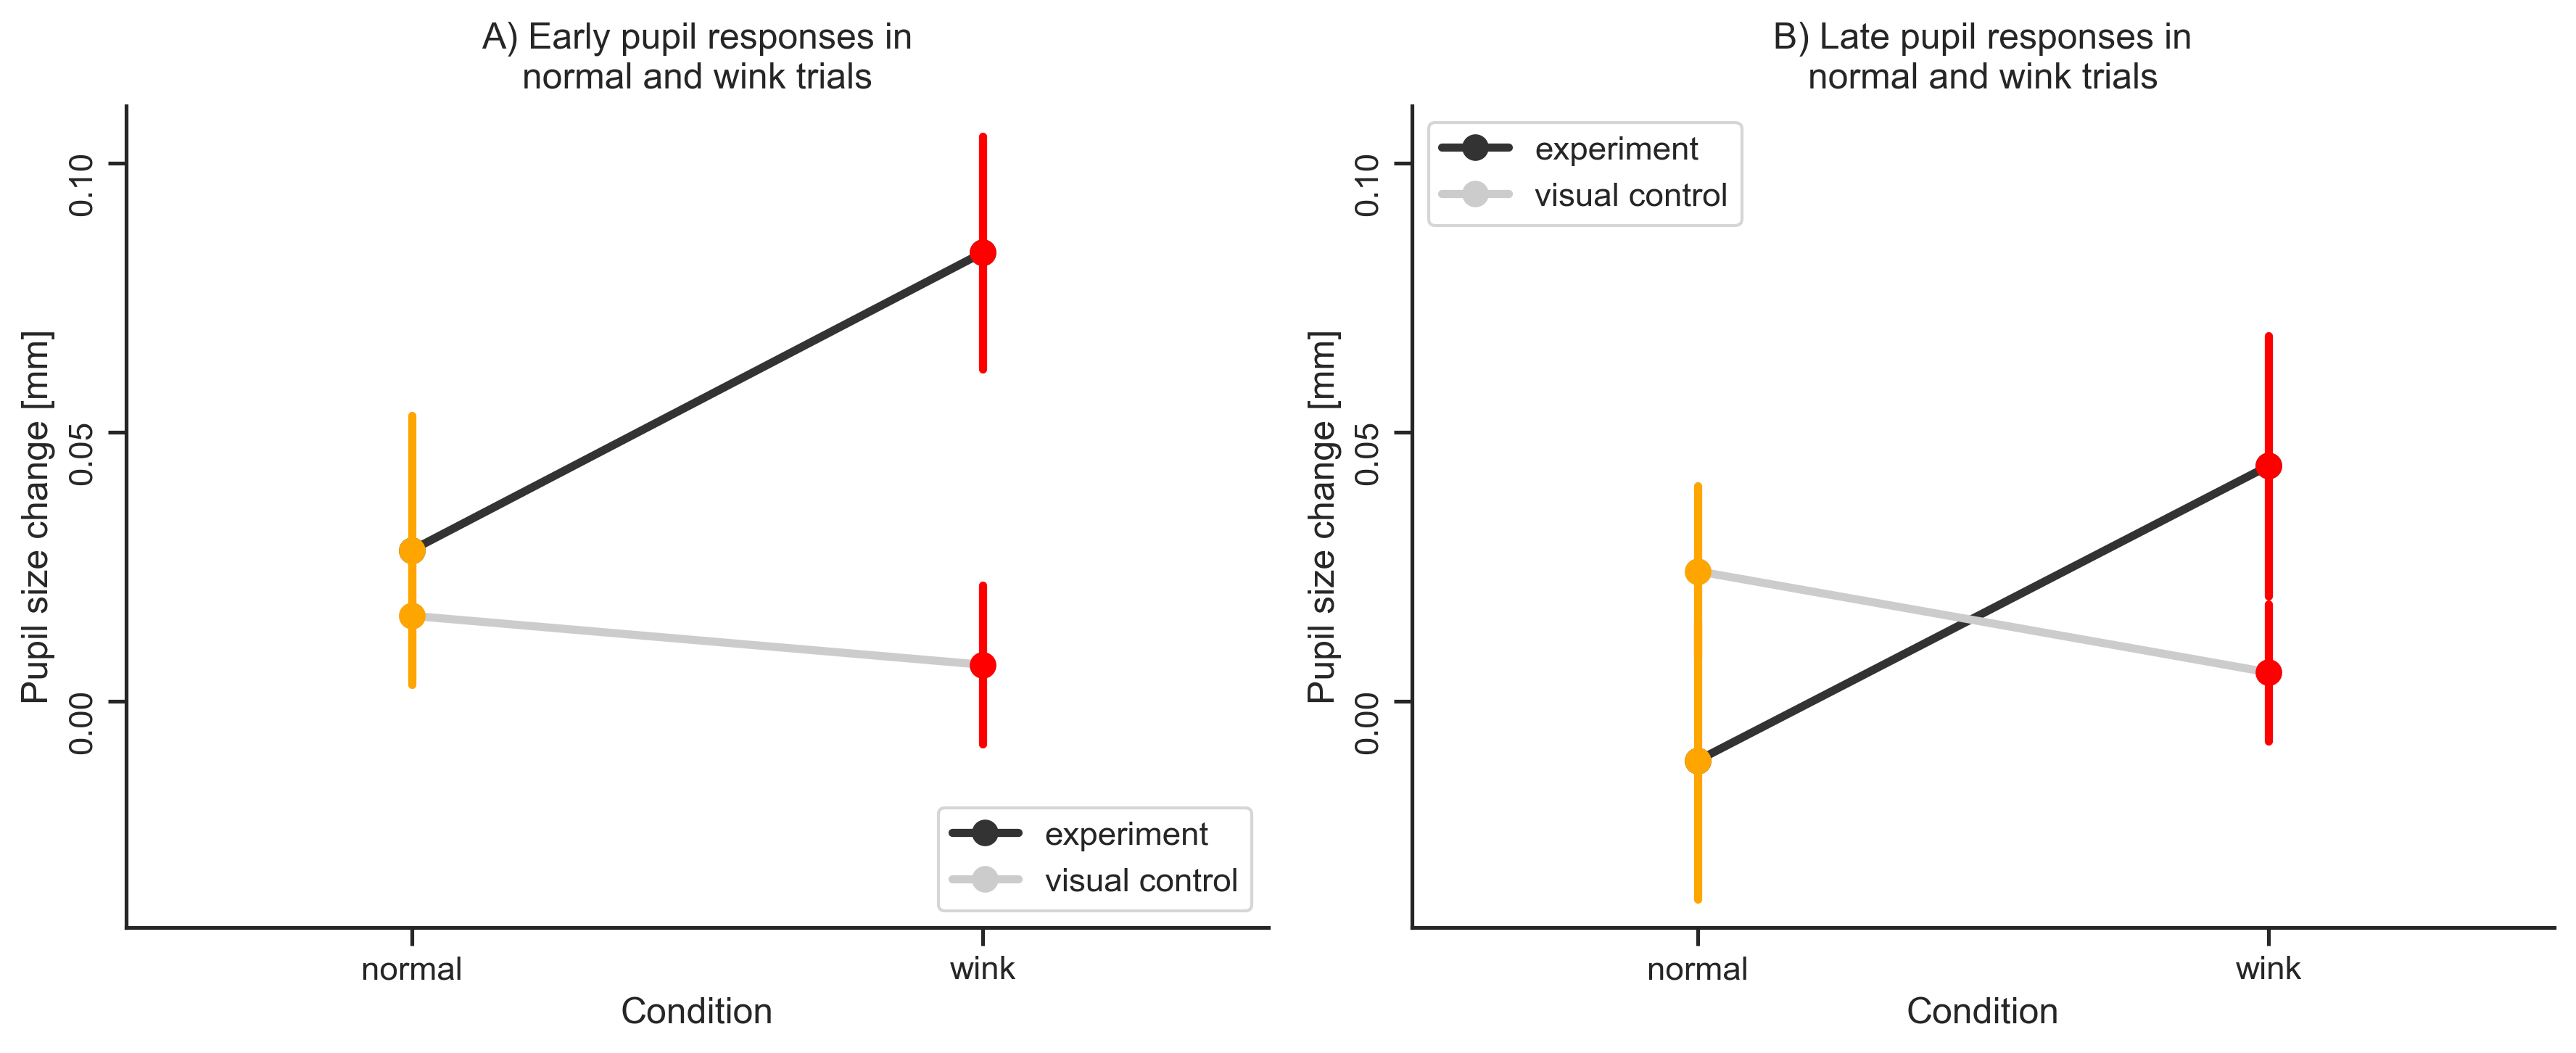

In [7]:
fig = plt.figure(figsize=(12, 5), dpi=300)
ax1, ax2 = fig.subplots(nrows=1, ncols=2)

condInteraction(pp, ['normal', 'wink'], 'earlyPupil', ax=ax1)
ax1.set_title('A) Early pupil responses in\nnormal and wink trials')

condInteraction(pp, ['normal', 'wink'], 'latePupil', ax=ax2)
ax2.set_title('B) Late pupil responses in\nnormal and wink trials')

ylim = min(ax1.get_ylim()[0], ax2.get_ylim()[0]), max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)

plt.tight_layout()
plt.rcParams['pdf.fonttype'] = 42
#fig.savefig(os.path.join(output_dir, f'figureS2.png'))
#fig.savefig(os.path.join(output_dir, f'figureS2.pdf'))
plt.show()

In [8]:
def testInteraction(df, cond1, cond2):
    dff = df.query('(condType==@cond1) | (condType==@cond2)')
    for field in ('earlyPupil', 'latePupil'):
        for session in ('experiment', 'visual'):
            res = pg.ttest(df.query('session.str.endswith(@session) & (condType==@cond1)')[field],
                           df.query('session.str.endswith(@session) & (condType==@cond2)')[field],
                           paired=True)
            display(res.style.set_caption(f'{field} {session}'))
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=FutureWarning)
            res = pg.rm_anova(dff, dv=field, within=['session', 'condType'], subject='subjectId', effsize='np2')
        display(res.style.set_caption(field))

In [9]:
pp.groupby(['session', 'subjectId', 'condType']).mean().groupby(['session', 'condType']).mean()

earlyPupil  latePupil
session       condType                       
wn_experiment normal      0.028071  -0.011011
              wink        0.083363   0.043752
wn_visual     normal      0.015899   0.024183
              wink        0.006806   0.005381

In [10]:
testInteraction(pp, 'wink', 'normal')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.843087,19,two-sided,0.001096,[0.03 0.09],0.529529,33.757,0.613120


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.480058,19,two-sided,0.636666,[-0.05 0.03],0.151712,0.258,0.098819


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,session,0.039365,1,19,0.039365,4.794315,0.041237,0.041237,0.201490,1.000000
1,condType,0.010672,1,19,0.010672,6.405193,0.020369,0.020369,0.252121,1.000000
2,session * condType,0.020727,1,19,0.020727,5.192432,0.034421,0.034421,0.214630,1.000000


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.441017,19,two-sided,0.024607,[0.01 0.1 ],0.490581,2.444,0.548750


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.845849,19,two-sided,0.408164,[-0.07 0.03],0.292032,0.319,0.236627


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,session,0.000050,1,19,0.000050,0.006591,0.936146,0.936146,0.000347,1.000000
1,condType,0.006466,1,19,0.006466,1.304580,0.267569,0.267569,0.064251,1.000000
2,session * condType,0.027059,1,19,0.027059,5.393113,0.031478,0.031478,0.221092,1.000000
